# HW4: Model Metrics and Calibration

### About:

For this assignment, you will use two separate datasets which consist of predictions along with true labels. You will plot different metrics and plots to evaluate and compare the two classifiers. For the tasks 1-4 below, do not use the implementations provided in `scikit-learn`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
output_1 = pd.read_csv('./assets/example_output.csv')

In [3]:
output_2 = pd.read_csv('./assets/example_output2.csv')

In [4]:
output_1.head()

,outcome,prediction
0,1,0.988018
1,1,0.986377
2,1,0.981420
3,1,0.980582
4,1,0.975002


In [5]:
output_2.head()

,outcome,prediction
0,0,0.983176
1,1,0.972331
2,1,0.932701
3,0,0.908685
4,1,0.907392


## Task 1: Confusion Matrix [10 pts]

Write a function that takes in a dataframe with 2 columns: outcome and prediction, and returns the confusion matrix for a given threshold. You can choose to represent the confusion matrix however you choose (as a list of lists, or numpy arrays), but be sure to include the number of True Positives, False Positives, True Negatives, and False Negatives.

In [6]:
def CalConfMatr(df, threshold):
    df_copy = df.copy()
    predict = lambda x: x >= threshold
    df_copy['prediction'] = df_copy['prediction'].apply(predict)
    TP = len(df_copy[(df_copy['outcome']==1) & (df_copy['prediction']==1)])
    FP = len(df_copy[(df_copy['outcome']==0) & (df_copy['prediction']==1)])
    FN = len(df_copy[(df_copy['outcome']==1) & (df_copy['prediction']==0)])
    TN = len(df_copy[(df_copy['outcome']==0) & (df_copy['prediction']==0)])
    return np.array([[TP, FP],[FN, TN]])

Apply this function to both `output_1` and `output_2` with thresholds of 0.25, 0.5, and 0.75.

In [7]:
print('Output1 confusion matrix (threshold=0.25):')
print(CalConfMatr(output_1, 0.25))
print('Output1 confusion matrix (threshold=0.5):')
print(CalConfMatr(output_1, 0.5))
print('Output1 confusion matrix (threshold=0.75):')
print(CalConfMatr(output_1, 0.75))

Output1 confusion matrix (threshold=0.25):
[[   47    74]
 [  227 13316]]
Output1 confusion matrix (threshold=0.5):
[[   28    16]
 [  246 13374]]
Output1 confusion matrix (threshold=0.75):
[[   15     7]
 [  259 13383]]


In [8]:
print('Output2 confusion matrix (threshold=0.25):')
print(CalConfMatr(output_2, 0.25))
print('Output2 confusion matrix (threshold=0.5):')
print(CalConfMatr(output_2, 0.5))
print('Output2 confusion matrix (threshold=0.75):')
print(CalConfMatr(output_2, 0.75))

Output2 confusion matrix (threshold=0.25):
[[   52   135]
 [  256 15425]]
Output2 confusion matrix (threshold=0.5):
[[   26    33]
 [  282 15527]]
Output2 confusion matrix (threshold=0.75):
[[   13    11]
 [  295 15549]]


## Task 2: Receiver Operating Characteristic [15 pts]

As we mentioned in class, the Receiver Operating Characteristic looks at the sensitivity and specificity of a given classifier over all possible thresholds. Write a function that takes in the dataframe of predictions and outcomes and returns a grid of sensitivities and (1 - specificity) to graph an ROC curve. For each of the dataframes, graph the ROC curve and add a line to show the theoretically random classifier. Plot the curves on the same plot. 

In [9]:
def ROC(df):
    N0 = len(df[df['outcome']==0])
    N1 = len(df[df['outcome']==1])
    df_sorted = df.sort_values(by='prediction', ascending=False)
    df_sorted = df_sorted.reset_index(drop=True)
    tpr_fpr = np.array([CalConfMatr(df_sorted, threshold)[0]/[N1,N0] for threshold in tqdm(df_sorted['prediction'].unique(), total=df_sorted['prediction'].unique().shape[0], leave=False)])
    return tpr_fpr

In [10]:
tpr_fpr1 = ROC(output_1)
tpr_fpr2 = ROC(output_2)

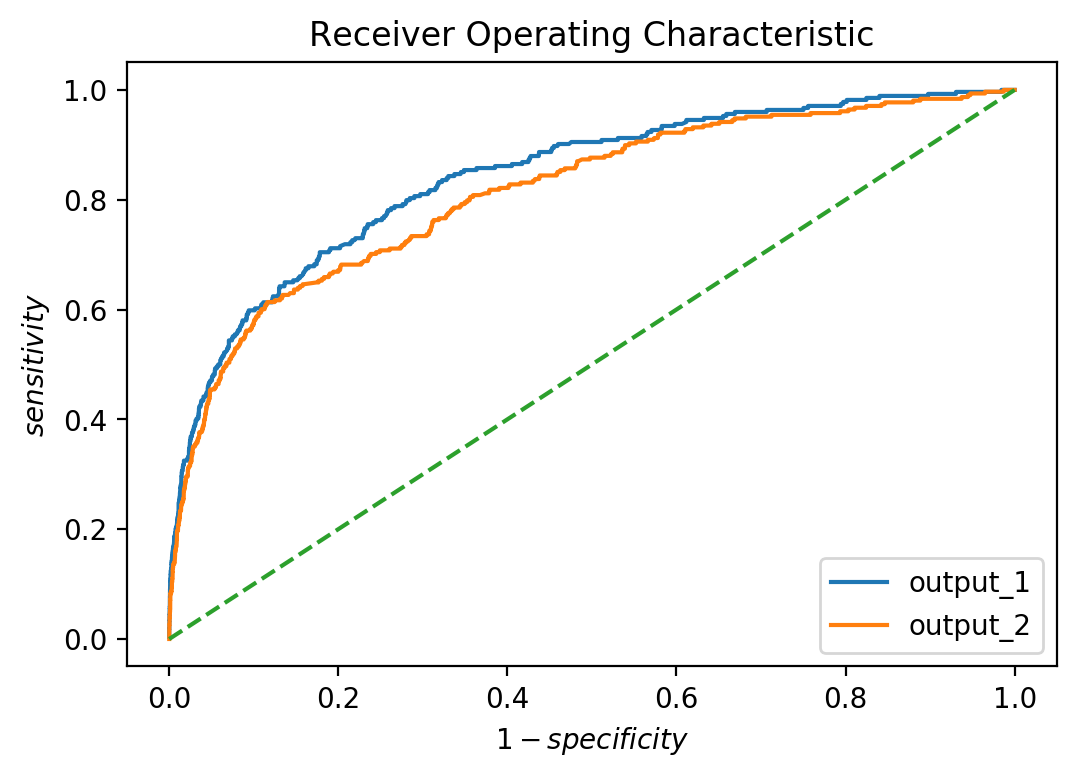

In [11]:
plt.figure(dpi=200)
plt.plot(tpr_fpr1[:, 1], tpr_fpr1[:, 0], label='output_1')
plt.plot(tpr_fpr2[:, 1], tpr_fpr2[:, 0], label='output_2')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('$1-specificity$')
plt.ylabel('$sensitivity$')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Task 3: Precision Recall Curve [15 pts]

For inbalanced classes, the Receiver Operating Characteristic can be a misleading measure of binary classification performance. Instead, it can be useful to look at points on the Precision-Recall curve. Similarly to the previous task, plot the two dataframes above on a Precision-Recall curve to compare the two classifiers.

In [12]:
def Precision(df):
    df_sorted = df.sort_values(by='prediction', ascending=False)
    df_sorted = df_sorted.reset_index(drop=True)
    precision = np.array([CalConfMatr(df_sorted, threshold)[0,0]/(sum(CalConfMatr(df_sorted, threshold)[0])) for threshold in tqdm(df_sorted['prediction'].unique(), total=df_sorted['prediction'].unique().shape[0], leave=False)])
    return precision

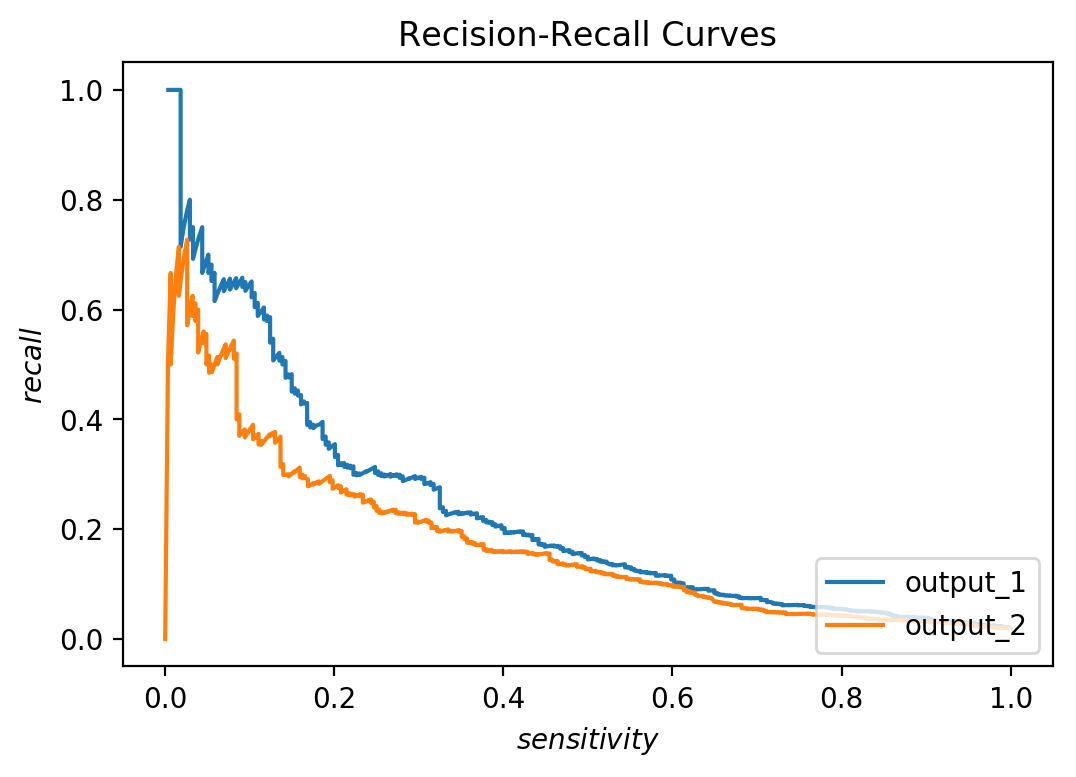

In [13]:
precision1 = Precision(output_1)
precision2 = Precision(output_2)
plt.figure(dpi=200)
plt.plot(tpr_fpr1[:, 0], precision1, label='output_1')
plt.plot(tpr_fpr2[:, 0], precision2, label='output_2')
plt.xlabel('$sensitivity$')
plt.ylabel('$recall$')
plt.title('Recision-Recall Curves')
plt.legend(loc="lower right")
plt.show()

## Task 4: Calibration Plot [15 pts]

For each of the classifiers, plot the calibration curve. The y-axis represents the predicted probabilities for each decile. You can plot the points using the middle of each decile (0.05, 0.15, etc.). The x-axis should contain the empirical proportion of positive examples for that predicted probabilities in that decile. For example, if for all examples that have a predicted probabilitiy between 0 and .1 there are 20/100 positive examples, the coordinate would be (0.2, 0.05).

In [10]:
def Calibration(df):
    y = np.array([i*0.1+0.05 for i in range(0,10)])
    x = np.array([df[(df['prediction']>=(i*0.1)) & (df['prediction']<=(i*0.1+0.1))]['outcome'].mean() for i in range(0,10)])
    return x, y

In [11]:
x1, y1 = Calibration(output_1)
x2, y2 = Calibration(output_2)

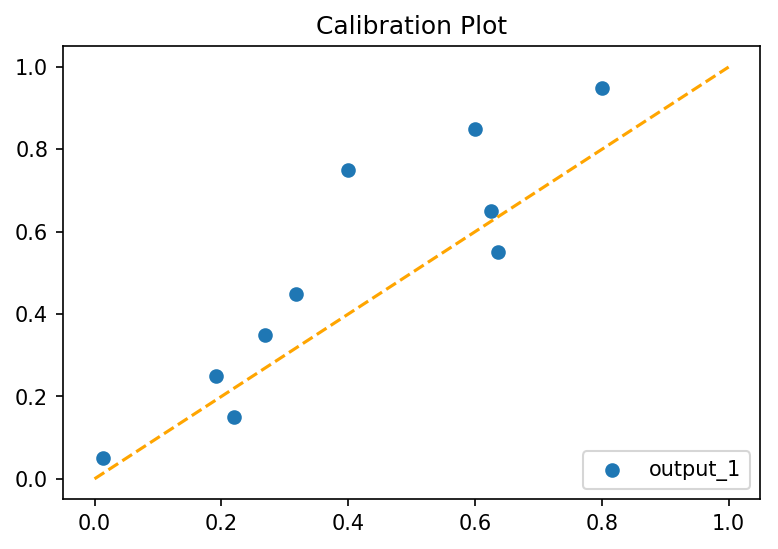

In [17]:
plt.figure(dpi=150)
plt.scatter(x1, y1, label='output_1')
plt.plot([0, 1], [0, 1], color = 'orange', linestyle='--')
plt.title('Calibration Plot')
plt.legend(loc="lower right")
plt.show()

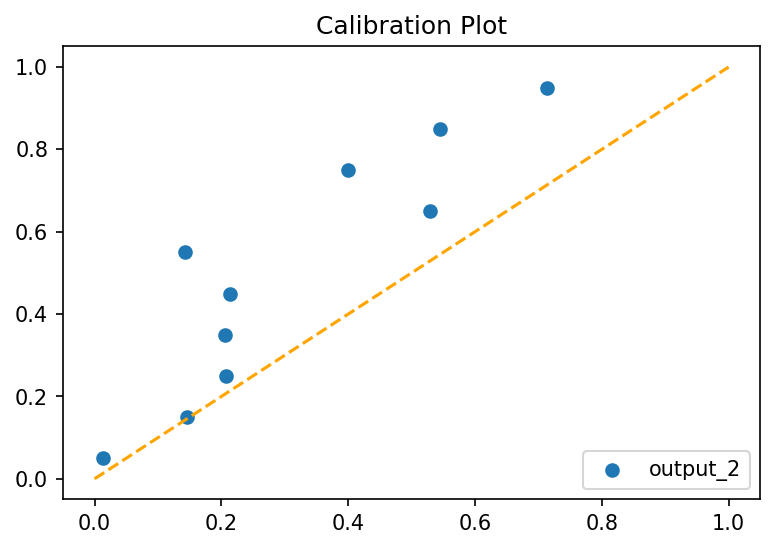

In [19]:
plt.figure(dpi=150)
plt.scatter(x2, y2, label='output_2')
plt.plot([0, 1], [0, 1], color = 'orange', linestyle='--')
plt.title('Calibration Plot')
plt.legend(loc="lower right")
plt.show()

## Task 5: Platt Scaling [45 pts]

The two datasets that you have been using are actually models that have been fit on two separate test sets. Therefore, we can use one dataset to try and calibrate the other. Although the ideal procedure would involve training the calibration model using cross-validation, we can attempt a post-hoc calibration by fitting a logistic regression using an intercept and the predictions and using the outcome as the target. Using the `output_1`, fit a logistic regression (you may use scikit-learn here if you wish) and apply it to the output of `output_2`. Afterwards, plot the calibration curve for the updated `output_2`. Has the calibration improved? 

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(output_1[['prediction']], output_1['outcome'])

/Users/alice/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


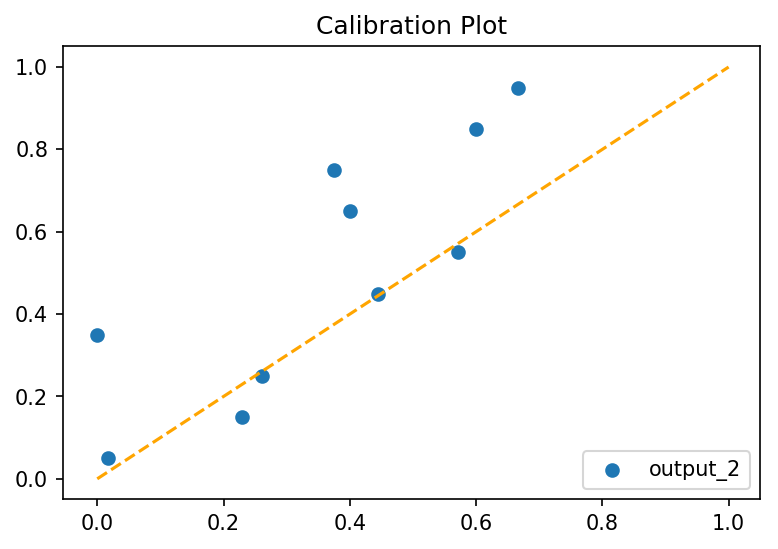

In [22]:
output_2_copy = output_2.copy()
output_2_copy['prediction'] = clf.predict_proba(output_2[['prediction']])[:,1]
x, y = Calibration(output_2_copy)
plt.figure(dpi=150)
plt.scatter(x, y, label='output_2')
plt.plot([0, 1], [0, 1], color = 'orange', linestyle='--')
plt.title('Calibration Plot')
plt.legend(loc="lower right")
plt.show()

Yes, the calibration is improved.